In [1]:
import sys
sys.path.append('./')
from os import path
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from util.table_converter import TableConverter, TableProps;
from generator.constant import Constant
from statistics import mean, median, variance, stdev

In [2]:
target_project_names = list(map(lambda s : s.split('/')[-1].split('.')[0], glob('../compile_information/*.json')))
target_project_names.remove('template')
target_project_names.remove('compile_information')

target_project_root_paths = [Constant.local_project_root_path + '/' + tpn for tpn in target_project_names]

project_root_path = Constant.output_root_path + '/' + 'project.csv'
project_df = pd.read_csv(project_root_path)

file_root_path = Constant.output_root_path + '/' + 'file.csv'
file_df = pd.read_csv(file_root_path)

available_macro_root_path = Constant.output_root_path + '/' + 'available_macros.csv'
available_macro_df = pd.read_csv(available_macro_root_path)

used_macro_root_path = Constant.output_root_path + '/' + 'used_macros.csv'
used_macro_df = pd.read_csv(used_macro_root_path)

defined_macro_root_path = Constant.output_root_path + '/' + 'defined_macros.csv'
defined_macro_df = pd.read_csv(defined_macro_root_path)

tvc = TableConverter()

local_project_root_path = Constant.local_project_root_path

In [3]:
def show_fig(data, title: str, xlabel: str, ylabel: str, set_log=True):
    plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
    fig, ax = plt.subplots()
    if (set_log):
        ax.set_xscale('log')
        ax.set_yscale('log')
    for dt in data:
        ax.scatter([dt[1]], [dt[2]], label=dt[0], edgecolors='none')
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend()
    ax.grid(True)

def build_project_id_name_mapper():
    id_name_mapper = {i[0]: i[1] for t, i in project_df.iterrows()}
    return id_name_mapper
id_name_mapper = build_project_id_name_mapper()

In [4]:
def build_project_id_LOC_builder():
    id_loc_mapper = {}
    for id, name in id_name_mapper.items():
        target_project_root = local_project_root_path + '/' + name
        if not path.exists(target_project_root):
            continue
        c_files = glob('{}/**/*.c'.format(target_project_root), recursive=True)
        loc = 0
        for file_path in c_files:
            with open (file_path, mode='r', errors='ignore') as f:
                loc += len(f.readlines())
        id_loc_mapper[id] = loc
    return id_loc_mapper
projectId_loc_mapper = build_project_id_LOC_builder()

In [5]:
def build_project_loc_available_macro_count_data():
    available_macro_file_df = pd.merge(available_macro_df, file_df, on='file_id', how='inner')
    res = available_macro_file_df.groupby('project_id').count()['id']
    project_id_available_count_mapper = {re[0]: re[1] for re in res.iteritems()}
    data = []
    for project_id, available_count in project_id_available_count_mapper.items():
        data.append([id_name_mapper[project_id], projectId_loc_mapper[project_id], available_count])
    return data

def build_project_loc_used_macro_count_data():
    used_macro_file_df = pd.merge(used_macro_df, file_df, on='file_id', how='inner')
    res = used_macro_file_df.groupby('project_id').count()['id']
    project_id_used_count_mapper = {re[0]: re[1] for re in res.iteritems()}
    data = []
    for project_id, used_count in project_id_used_count_mapper.items():
        data.append([id_name_mapper[project_id], projectId_loc_mapper[project_id], used_count])
    return data

def build_project_loc_defined_macro_count_data():
    defined_macro_file_df = pd.merge(defined_macro_df, file_df, on='file_id', how='inner')
    res = defined_macro_file_df.groupby('project_id').count()['id']
    project_id_defined_count_mapper = {re[0]: re[1] for re in res.iteritems()}
    data = []
    for project_id, used_count in project_id_defined_count_mapper.items():
        data.append([id_name_mapper[project_id], projectId_loc_mapper[project_id], used_count])
    return data

class two_relation_builder():
    def __build_id_count_mapper(self, macro_df):
        macro_file_df = pd.merge(macro_df, file_df, on='file_id', how='inner')
        res = macro_file_df.groupby('project_id').count()['id']
        project_id_macro_count_mapper = {re[0]: re[1] for re in res.iteritems()}
        return project_id_macro_count_mapper

    def build_used_macro_count_available_macro_count_data(self):
        project_id_used_count_mapper = self.__build_id_count_mapper(used_macro_df)
        project_id_available_count_mapper = self.__build_id_count_mapper(available_macro_df)
        data = []
        for project_id, project_name in id_name_mapper.items():
            if project_id in project_id_used_count_mapper and project_id in project_id_available_count_mapper:
                data.append([project_name, project_id_used_count_mapper[project_id], project_id_available_count_mapper[project_id]])
        return data
    
    def build_defined_macro_count_available_macro_count_data(self):
        project_id_defined_macro_mapper = self.__build_id_count_mapper(defined_macro_df)
        project_id_available_macro_mapper = self.__build_id_count_mapper(available_macro_df)
        data = []
        for project_id, project_name in id_name_mapper.items():
            if project_id in project_id_defined_macro_mapper and project_id in project_id_available_macro_mapper:
                data.append([project_name, project_id_defined_macro_mapper[project_id], project_id_available_macro_mapper[project_id]])
        return data
    
    def build_used_macro_count_defined_macro_count_data(self):
        project_id_used_count_mapper = self.__build_id_count_mapper(used_macro_df)
        project_id_defined_macro_mapper = self.__build_id_count_mapper(defined_macro_df)
        data = []
        for project_id, project_name in id_name_mapper.items():
            if project_id in project_id_defined_macro_mapper and project_id in project_id_used_count_mapper:
                data.append([project_name, project_id_used_count_mapper[project_id], project_id_defined_macro_mapper[project_id]])
        return data


In [18]:
class macro_variance_builder():
    def calc_variance_with_project_id(self, macro_df, project_id):
        file_num = len(file_df.loc[file_df['project_id'] == project_id])
        target_file_df = file_df.loc[file_df['project_id'] == project_id]
        macro_file_df = pd.merge(macro_df, target_file_df, on='file_id', how='right')
        macro_count =len(pd.merge(macro_df, target_file_df, on='file_id', how='inner')) 
        macro_count_ave =  macro_count / file_num
        
        variance = (macro_file_df.groupby('file_id').count().filter(['id']).rename(columns={'id': 'macro_count'}) / macro_count_ave).pow(2).mean()
        return variance, macro_count

    def build_available_macro_variance_data(self):
        data = []
        for project_id, project_name in id_name_mapper.items():
            variance, macro_count = self.calc_variance_with_project_id(available_macro_df, project_id)
            if macro_count > 0:
                data.append([project_name, macro_count, variance])
        return data
    
    def build_defined_macro_variance_data(self):
        data = []
        for project_id, project_name in id_name_mapper.items():
            variance, macro_count = self.calc_variance_with_project_id(defined_macro_df, project_id)
            if macro_count > 0:
                data.append([project_name, macro_count, variance])
        return data 

    def build_used_macro_variance_data(self):
        data = []
        for project_id, project_name in id_name_mapper.items():
            variance, macro_count = self.calc_variance_with_project_id(used_macro_df, project_id)
            if macro_count > 0:
                data.append([project_name, macro_count, variance])
        return data

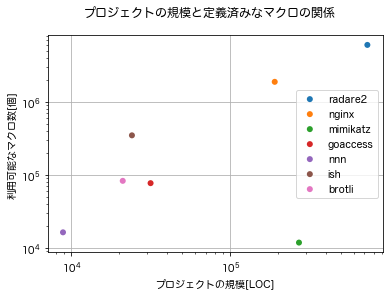

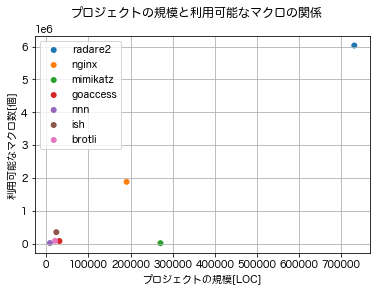

In [7]:
project_loc_availabel_macro_count_data = build_project_loc_available_macro_count_data()
show_fig(project_loc_availabel_macro_count_data, title='プロジェクトの規模と定義済みなマクロの関係', xlabel='プロジェクトの規模[LOC]', ylabel='展開可能なマクロ数[個]', set_log=True)
show_fig(project_loc_availabel_macro_count_data, title='プロジェクトの規模と展開可能なマクロの関係', xlabel='プロジェクトの規模[LOC]', ylabel='展開可能なマクロ数[個]', set_log=False)

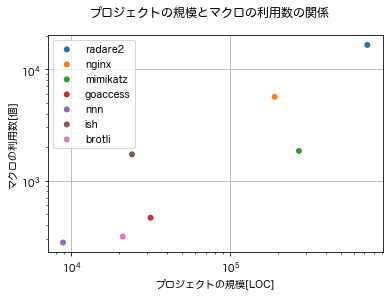

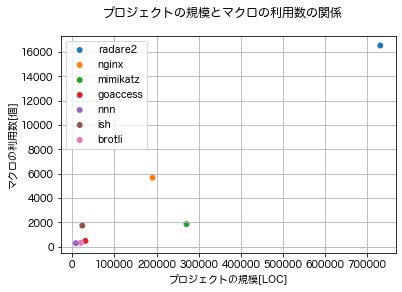

In [8]:
data = build_project_loc_used_macro_count_data()
show_fig(data, title='プロジェクトの規模とマクロの展開数の関係', xlabel='プロジェクトの規模[LOC]', ylabel='マクロの展開数[個]', set_log=True)
show_fig(data, title='プロジェクトの規模とマクロの展開数の関係', xlabel='プロジェクトの規模[LOC]', ylabel='マクロの展開数[個]', set_log=False)

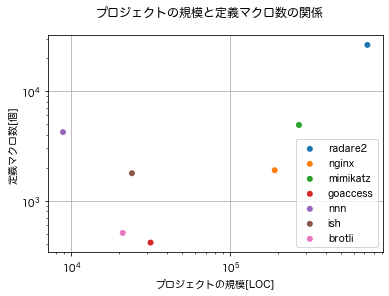

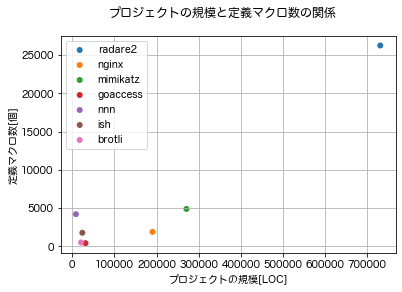

In [9]:
data = build_project_loc_defined_macro_count_data()
show_fig(data, title='プロジェクトの規模と定義マクロ数の関係', xlabel='プロジェクトの規模[LOC]', ylabel='定義マクロ数[個]', set_log=True)
show_fig(data, title='プロジェクトの規模と定義マクロ数の関係', xlabel='プロジェクトの規模[LOC]', ylabel='定義マクロ数[個]', set_log=False)

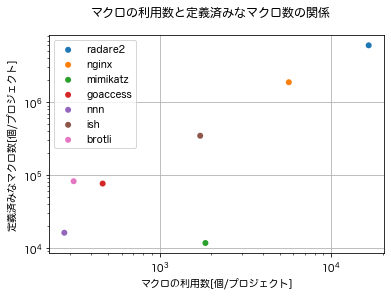

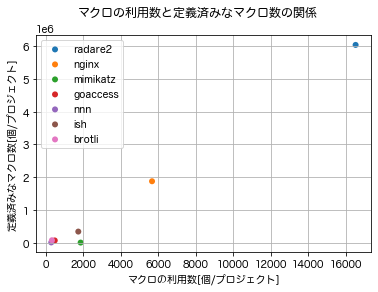

In [10]:
data = two_relation_builder().build_used_macro_count_available_macro_count_data()
show_fig(data, title='マクロの展開数と定義済みなマクロ数の関係', xlabel='マクロの展開数[個/プロジェクト]', ylabel='定義済みなマクロ数[個/プロジェクト]', set_log=True)
show_fig(data, title='マクロの展開数と定義済みなマクロ数の関係', xlabel='マクロの展開数[個/プロジェクト]', ylabel='定義済みなマクロ数[個/プロジェクト]', set_log=False)

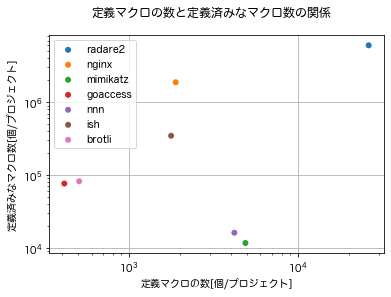

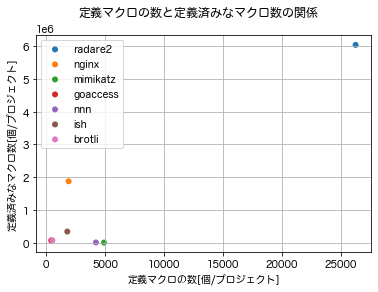

In [11]:
data = two_relation_builder().build_defined_macro_count_available_macro_count_data()
show_fig(data, title='定義マクロの数と定義済みなマクロ数の関係', xlabel='定義マクロの数[個/プロジェクト]', ylabel='定義済みなマクロ数[個/プロジェクト]', set_log=True)
show_fig(data, title='定義マクロの数と定義済みなマクロ数の関係', xlabel='定義マクロの数[個/プロジェクト]', ylabel='定義済みなマクロ数[個/プロジェクト]', set_log=False)

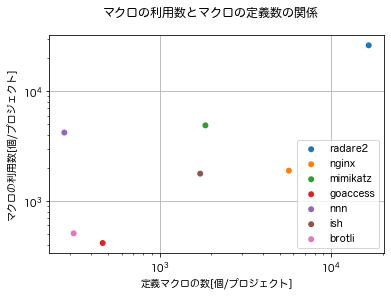

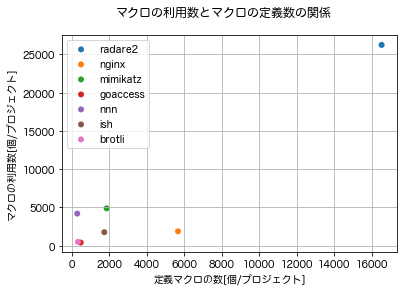

In [12]:
data = two_relation_builder().build_used_macro_count_defined_macro_count_data()
show_fig(data, title='マクロの展開数とマクロの定義数の関係', xlabel='定義マクロの数[個/プロジェクト]', ylabel='マクロの展開数[個/プロジェクト]', set_log=True)
show_fig(data, title='マクロの展開数とマクロの定義数の関係', xlabel='定義マクロの数[個/プロジェクト]', ylabel='マクロの展開数[個/プロジェクト]', set_log=False)

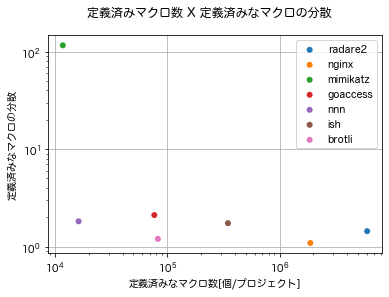

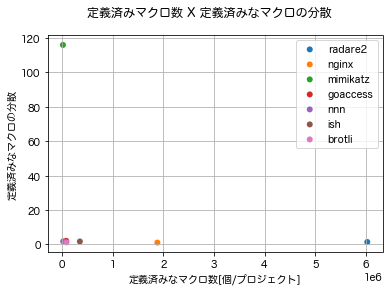

In [13]:
data = macro_variance_builder().build_available_macro_variance_data()
show_fig(data, title='定義済みマクロ数 X 定義済みなマクロの分散', xlabel='定義済みなマクロ数[個/プロジェクト]', ylabel='定義済みなマクロの分散', set_log=True)
show_fig(data, title='定義済みマクロ数 X 定義済みなマクロの分散', xlabel='定義済みなマクロ数[個/プロジェクト]', ylabel='定義済みなマクロの分散', set_log=False)

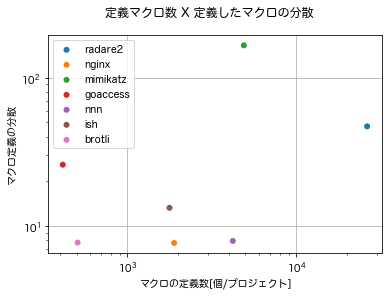

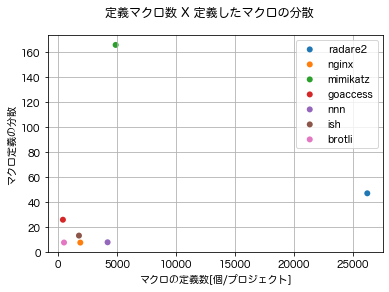

In [14]:
data = macro_variance_builder().build_defined_macro_variance_data()
show_fig(data, title='定義マクロ数 X 定義したマクロの分散', xlabel='マクロの定義数[個/プロジェクト]', ylabel='マクロ定義の分散', set_log=True)
show_fig(data, title='定義マクロ数 X 定義したマクロの分散', xlabel='マクロの定義数[個/プロジェクト]', ylabel='マクロ定義の分散', set_log=False)

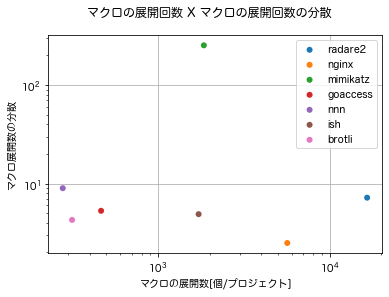

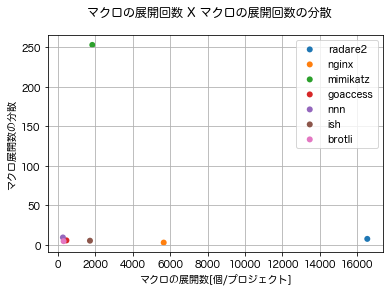

In [19]:
data = macro_variance_builder().build_used_macro_variance_data()
show_fig(data, title='マクロの展開回数 X マクロの展開回数の分散', xlabel='マクロの展開数[個/プロジェクト]', ylabel='マクロ展開数の分散', set_log=True)
show_fig(data, title='マクロの展開回数 X マクロの展開回数の分散', xlabel='マクロの展開数[個/プロジェクト]', ylabel='マクロ展開数の分散', set_log=False)

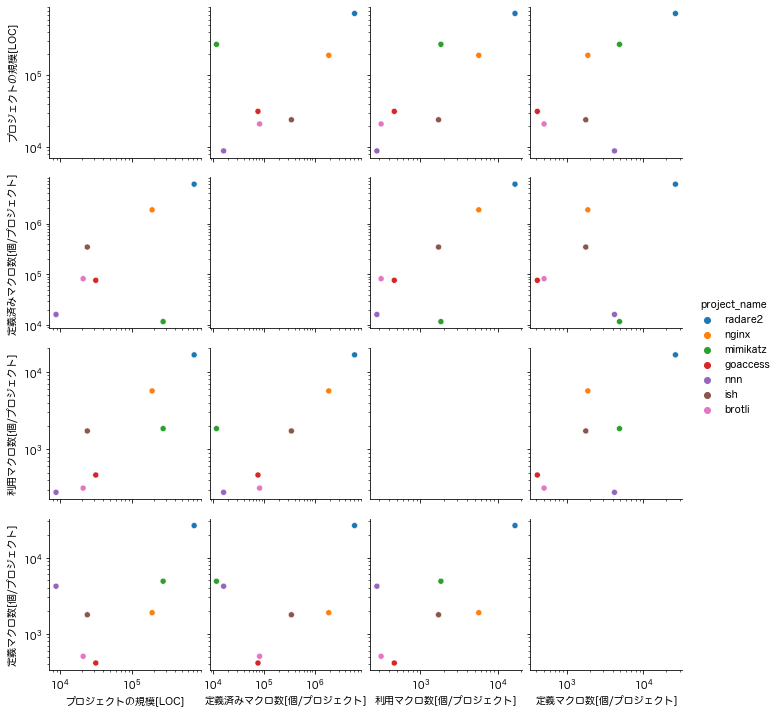

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


def build_dataFrame():
    project_loc_availabel_macro_count_data = build_project_loc_available_macro_count_data()
    used_macro_count_defined_macro_count_data = two_relation_builder().build_used_macro_count_defined_macro_count_data()
    data = [[la[0], la[1], la[2], ud[1], ud[2]] for la, ud in zip(project_loc_availabel_macro_count_data, used_macro_count_defined_macro_count_data)]
    index = [i[0] for i in project_loc_availabel_macro_count_data]
    columns = ['project_name', 'プロジェクトの規模[LOC]', '定義済みマクロ数[個/プロジェクト]', '展開マクロ数[個/プロジェクト]', '定義マクロ数[個/プロジェクト]']
    df = pd.DataFrame(data, index=index, columns=columns)
    return df
    # each rows assign single project.
    # print(project_loc_availabel_macro_count_data, used_macro_count_defined_macro_count_data)
    # columns: project_name, project_loc, available_macro_count, used_macro_count, define_macro_count



df = build_dataFrame()


pp = sns.pairplot(df, hue='project_name')
for ax in pp.axes.flat:
    ax.set(xscale='log', yscale='log')
    ax.set_xlabel(ax.get_xlabel(),fontsize=10)
    ax.set_ylabel(ax.get_ylabel(),fontsize=10)
plt.show()